# Tensorflow Serving

- 텐서플로우 서빙(TensorFlow Serving)은 구글에서 만든 유연하고(flexible), 고성능의(high-performance) serving 시스템.
- 프로덕션(production) 환경을 위해 고안된 머신러닝 모델을 serving 한다.
- 장점: 웹 프레임워크를 이용하는 경우와 비교하여 일반적으로 처리 속도가 빠름.
- 단점: 기존 api 서버와 별개로 인퍼런스 서버를 따로 구축해야 됨.(사실 단점이자 장점으로 서버가 분리되어 관리되기 쉽고 가장 안정적.)

### Tensorflow Serving VS Flask REST API
- 참조: https://roadcom.tistory.com/107
- 비교 대상
    - Flask REST API
    - REST API[Tensorflow Serving]
    - gRPC API[Tensorflow Serving]
- Model Serving Benchmark
    - 결과: gRPC(TF) > REST(TF) >> Flask > Flask+gunicorn 순

|Metric| gRPC (TF)| REST (TF)| Flask|	Flask+gunicorn|
|------|---|---|---|---|
|AVG (s)| 0.983|	1.624|	9.088|	9.394|
|STD (s)| 0.011|	0.021|	0.378|	0.348|

### 예제) MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
X_train = np.expand_dims(((x_train-127.5)/127.5),3)
X_test = np.expand_dims(((x_test-127.5)/127.5),3)

Y_train = tf.one_hot(y_train,10)
Y_test = tf.one_hot(y_test,10)

In [4]:
model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(28,28,1)),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAvgPool2D(),
    layers.Dense(10,activation='softmax')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 256)        0         
 2D)                                                    

In [6]:
model.compile(
    optimizer='adam',
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [7]:
model.fit(x=X_train,y=Y_train,batch_size=120,epochs=5,validation_split=0.2)

Epoch 1/5
400/400 [==============================] - 4s 6ms/step - loss: 0.2031 - accuracy: 0.9343 - val_loss: 0.0749 - val_accuracy: 0.9768
Epoch 2/5
400/400 [==============================] - 2s 5ms/step - loss: 0.0473 - accuracy: 0.9850 - val_loss: 0.0382 - val_accuracy: 0.9888
Epoch 3/5
400/400 [==============================] - 2s 5ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0298 - val_accuracy: 0.9914
Epoch 4/5
400/400 [==============================] - 2s 5ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.0273 - val_accuracy: 0.9920
Epoch 5/5
400/400 [==============================] - 2s 5ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0324 - val_accuracy: 0.9901


In [8]:
model.evaluate(x=X_test,y=Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0256 - accuracy: 0.9916


[0.025618936866521835, 0.991599977016449]

### saved_model 형식으로 저장
- Tensorflow Serving을 이용하기 위해서는 **saved model**형식으로 모델을 저장되어야 됨.
- 주의할 점은 Serving의 경우 자동으로 디렉터리 내에서 최신버전을 불러와서 서비을 하도록 되어있어, **버전에 대한 디렉토리가 꼭 존재해야 된다.** ex) model/mnist/1.1

In [9]:
tf.saved_model.save(model,'model/mnist/1')

INFO:tensorflow:Assets written to: model/mnist/1/assets


INFO:tensorflow:Assets written to: model/mnist/1/assets


In [53]:
n = np.random.randint(0,len(X_test))

In [56]:
X_test[n:n+1]

(1, 28, 28, 1)

### Docker 설정

In [ ]:
docker pull tensorflow/serving

In [ ]:
docker run --rm -t -p 8501:8501 -v "/home/changminkim/mnist/:/models/mnist" 
    -e MODEL_NAME=mnist tensorflow/serving &

### tensorflow/server에 모델 predict 요청

In [141]:
import json
import requests
from PIL import Image
import numpy as np

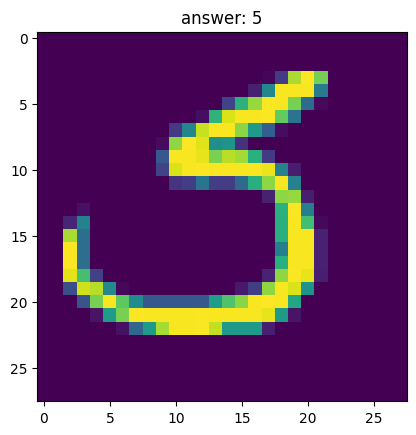

정답: 5


In [147]:
n = np.random.randint(0,len(X_test))
test_image = X_test[n:n+1]
address = 'http://changminkimserver29672.iptime.org:8501/v1/models/mnist:predict'
data = json.dumps({'instances':test_image.tolist()})

result = requests.post(address,data=data)
predictions = json.loads(str(result.content, 'utf-8'))

plt.imshow((test_image[0,:,:,0]+1)/2)
plt.title("answer: "+str(np.argmax(predictions['predictions'])))
plt.show()
print("정답:",np.argmax(predictions['predictions']))

### 속도 테스트

In [126]:
import time

In [138]:
test_image = X_train[:50000]
address = 'http://changminkimserver29672.iptime.org:8501/v1/models/mnist:predict'
data = json.dumps({'instances':test_image.tolist()})

In [140]:
start_time = time.time()
result = requests.post(address,data=data)
predictions = json.loads(str(result.content, 'utf-8'))['predictions']
last_time = time.time()

print(last_time-start_time)

21.70534038543701
